# SocraticFlanT5 - Caption Generation (baseline) | DL2 Project, May 2023
---

This notebook downloads the images from the validation split of the [MS COCO Dataset (2017 version)](https://cocodataset.org/#download) and the corresponding ground-truth captions and generates captions based on the Socratic model pipeline outlined below. The caption will be generated by the baseline approach:
* Baseline: a Socratic model based on the work by [Zeng et al. (2022)](https://socraticmodels.github.io/) where GPT-3 is replaced by [FLAN-T5-xl](https://huggingface.co/docs/transformers/model_doc/flan-t5). 

In other words, the goal of this jupyter notebook is to reproduce the Socratic Models paper with the Flan-T5 model. This provides a baseline for us to build upon.

## Imports

In [10]:
# Package loading
import matplotlib.pyplot as plt
import pandas as pd
from transformers import set_seed
import os
import numpy as np

# Local imports
from image_captioning import ClipManager, ImageManager, VocabManager, FlanT5Manager
from image_captioning import LmPromptGenerator as pg
from utils import get_device

## Set seed

In [2]:
# Set the transformers seed
set_seed(42)

## Set device

In [3]:
# Set the device to use
device = get_device()

## Class instantiation

In [4]:
# Instantiate the clip manager
clip_manager = ClipManager(device)

# Instantiate the image manager
image_manager = ImageManager()

# Instantiate the vocab manager
vocab_manager = VocabManager()

# Instantiate the Flan T5 manager
flan_manager = FlanT5Manager()

load_places starting!
load_places took 0.0s!
load_objects starting!
load_objects took 0.0s!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Set image path

In [5]:
# img_paths = {
#     'Dining room': 'demo_img.png',
#     'Monkey with gun': 'monkey_with_gun.jpg',
#     'Cute bear': 'cute_bear.jpg',
#     'Astronaut with beer': 'astronaut_with_beer.jpg'
# }
img_paths = {
    'Dining room': 'demo_img.png',
    'Astronaut with beer': 'astronaut_with_beer.jpg'
}

## Create text embeddings

In [11]:
# Calculate the place features
if not os.path.exists('cache/place_feats.npy'):

    # Calculate the place features
    place_feats = clip_manager.get_text_feats([f'Photo of a {p}.' for p in vocab_manager.place_list])
    np.save('cache/place_feats.npy', place_feats)
else:
    place_feats = np.load('cache/place_feats.npy')

# Calculate the object features
if not os.path.exists('cache/object_feats.npy'):
    # Calculate the object features
    object_feats = clip_manager.get_text_feats([f'Photo of a {o}.' for o in vocab_manager.object_list])
    np.save('cache/object_feats.npy', object_feats)
else:
    object_feats = np.load('cache/object_feats.npy')

    

# # Calculate the place features
# place_feats = clip_manager.get_text_feats([f'Photo of a {p}.' for p in vocab_manager.place_list])

# # Calculate the object features
# object_feats = clip_manager.get_text_feats([f'Photo of a {o}.' for o in vocab_manager.object_list])

## Load image and compute image embedding

Dining room:


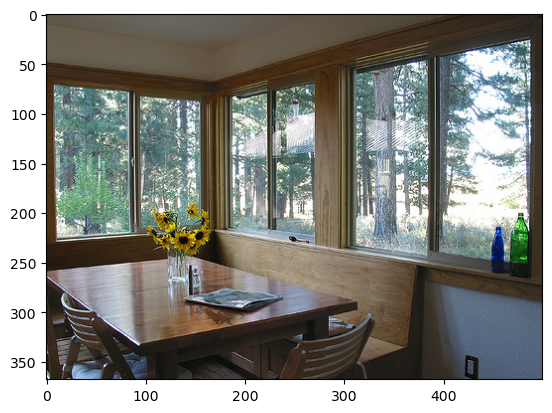

Astronaut with beer:


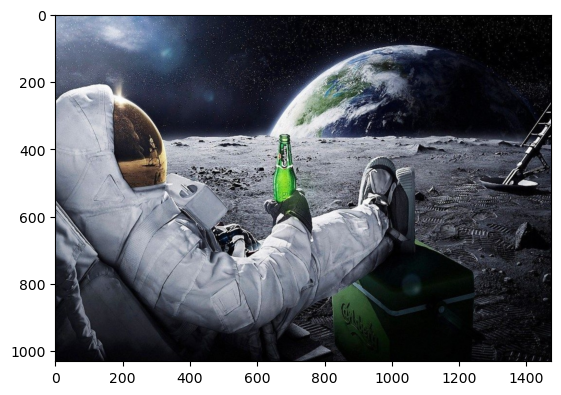

In [12]:
# Load image.
img_dic = {img_name: image_manager.load_image(img_path) for img_name, img_path in img_paths.items()}
# Get image representation
img_feat_dic = {img_name: clip_manager.get_img_feats(img) for img_name, img in img_dic.items()}
# Show the image
for img_name, img in img_dic.items():
    print(f'{img_name}:')
    plt.imshow(img)
    plt.show()

## Zero shot VLM - Image type classification

In [13]:
# Zero-shot VLM: classify image type.
img_types = ['photo', 'cartoon', 'sketch', 'painting']
img_types_feats = clip_manager.get_text_feats([f'This is a {t}.' for t in img_types])

# Create a dictionary to store the image types
img_type_dic = {}
for img_name, img_feat in img_feat_dic.items():
    sorted_img_types, img_type_scores = clip_manager.get_nn_text(img_types, img_types_feats, img_feat)
    img_type_dic[img_name] = sorted_img_types[0]
    print(f'Image type for "{img_name}": {img_type_dic[img_name]}')

Image type for "Dining room": photo
Image type for "Astronaut with beer": photo


## Zero shot VLM - Number of people classification

In [14]:
# Zero-shot VLM: classify number of people.
ppl_texts_bool = ['no people', 'people']
ppl_feats_bool = clip_manager.get_text_feats([f'There are {p} in this photo.' for p in ppl_texts_bool])

ppl_texts_mult = ['is one person', 'are two people', 'are three people', 'are several people', 'are many people']
ppl_feats_mult = clip_manager.get_text_feats([f'There {p} in this photo.' for p in ppl_texts_mult])

# Create a dictionary to store the number of people
num_people_dic = {}

for img_name, img_feat in img_feat_dic.items():
    sorted_ppl_texts, ppl_scores = clip_manager.get_nn_text(ppl_texts_bool, ppl_feats_bool, img_feat)
    ppl_result = sorted_ppl_texts[0]
    if ppl_result == 'people':
        sorted_ppl_texts, ppl_scores = clip_manager.get_nn_text(ppl_texts_mult, ppl_feats_mult, img_feat)
        ppl_result = sorted_ppl_texts[0]
    else:
        ppl_result = f'are {ppl_result}'

    num_people_dic[img_name] = ppl_result
    print(f'Number of people in "{img_name}": {ppl_result}')

Number of people in "Dining room": are no people
Number of people in "Astronaut with beer": are no people


## Zero shot VLM - Image place classification

In [15]:
# Zero-shot VLM: classify places.
place_topk = 3

# Create a dictionary to store the number of people
location_dic = {}
for img_name, img_feat in img_feat_dic.items():
    sorted_places, places_scores = clip_manager.get_nn_text(vocab_manager.place_list, place_feats, img_feat)
    location_dic[img_name] = sorted_places[0]
    print(f'Location for {img_name}: {location_dic[img_name]}')

Location for Dining room: indoor bow window
Location for Astronaut with beer: beer garden


## Zero shot VLM - Image object classification

In [16]:
# Zero-shot VLM: classify objects.
obj_topk = 10

# Create a dictionary to store the similarity of each object with the images
obj_list_dic = {}
for img_name, img_feat in img_feat_dic.items():
    sorted_obj_texts, obj_scores = clip_manager.get_nn_text(vocab_manager.object_list, object_feats, img_feat)
    object_list = ''
    for i in range(obj_topk):
        object_list += f'{sorted_obj_texts[i]}, '
    object_list = object_list[:-2]
    obj_list_dic[img_name] = object_list
    print(f'Top 10 objects recognised for "{img_name}":\n{object_list}\n')

Top 10 objects recognised for "Dining room":
flash, carinate, carinate bird, flying bird, muntjac, barking deer, bedrock, bathing cap, swimming cap, camera lens, optical lens, inverter, rolling mill, office, business office, basketball equipment

Top 10 objects recognised for "Astronaut with beer":
stately home, ball field, baseball field, diamond, plain, field, champaign, plum tomato, snack food, taro, taro root, cocoyam, dasheen, edda, black birch, river birch, red birch, Betula nigra, game equipment, kitchen utensil, durian



## Zero shot LM - Caption generation

In [17]:
# Zero-shot LM: generate captions.
num_captions = 50

# Set LM params
model_params = {'temperature': 0.9, 'max_length': 40, 'do_sample': True}

# Create dictionaries to store the outputs
prompt_dic = {}
sorted_caption_map = {}
caption_score_map = {}

for img_name in img_dic:
    # Create the prompt for the language model
    prompt_dic[img_name] = pg.create_baseline_lm_prompt(
        img_type_dic[img_name], num_people_dic[img_name], location_dic[img_name], obj_list_dic[img_name]
    )

    # Generate the caption using the language model
    caption_texts = flan_manager.generate_response(num_captions * [prompt_dic[img_name]], model_params)

    # Zero-shot VLM: rank captions.
    caption_feats = clip_manager.get_text_feats(caption_texts)
    sorted_captions, caption_scores = clip_manager.get_nn_text(caption_texts, caption_feats, img_feat_dic[img_name])
    sorted_caption_map[img_name] = sorted_captions
    caption_score_map[img_name] = dict(zip(sorted_captions, caption_scores))
    print(f'Best generate caption for "{img_name}": "{sorted_captions[0]}"\n')

generate_response starting!
generate_response took 1221.8s!
Best generate caption for "Dining room": "There are no people in this photo. It was taken at an i, n, or d. The area has a natural background."

generate_response starting!
generate_response took 1252.6s!
Best generate caption for "Astronaut with beer": "i think this photo was taken at a b, e, or e. it was taken at b, e, or e. There are no people."



## Saving the outputs

In [ ]:
data_list = []
for img_name in img_dic:
    generated_caption = sorted_caption_map[img_name][0]
    data_list.append({
        'image_name': img_name,
        'image_path': img_paths[img_name],
        'generated_caption': generated_caption,
        'cosine_similarity': caption_score_map[img_name][generated_caption]
    })
pd.DataFrame(data_list).to_csv(f'baseline_outputs.csv', index=False)